In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from Deep_Learning.Representation_Learning.SimCLR.train import train
from Deep_Learning.Representation_Learning.SimCLR.model import Model

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Files already downloaded and verified
Files already downloaded and verified


c:\Users\joeag\Documents\venvs\ml-env\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


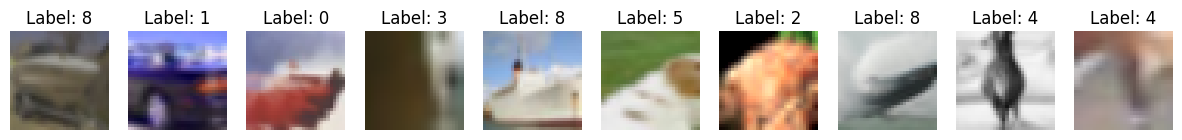

Max value: tensor(1., device='cuda:0')
Min value: tensor(0., device='cuda:0')


In [3]:
dataset = datasets.CIFAR10(root='../Datasets/', train=True, transform=transforms.ToTensor(), download=True)
t_dataset = datasets.CIFAR10(root='../Datasets/', train=False, transform=transforms.ToTensor(), download=True)

VAL_RATIO = 0.2
n_val = int(len(dataset) * VAL_RATIO)
n_train = len(dataset) - n_val
train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val])

train_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform(),
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform()
])

color_jitter = transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
augmentation = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.Resize(32, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([color_jitter], p=0.2),
    transforms.RandomGrayscale(p=0.2),
    # transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
])

train_set = PreloadedDataset.from_dataset(train_set, train_transform, device)
val_set = PreloadedDataset.from_dataset(val_set, val_transform, device)
test_set = PreloadedDataset.from_dataset(t_dataset, val_transform, device)

# Show example images
fig, axes = plt.subplots(1, 10, figsize=(15,5))
for i, ax in enumerate(axes):
    img, label = train_set[i]
    img = augmentation(img)
    ax.imshow(img.squeeze().cpu().permute(1, 2, 0).numpy())
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.show()

# print max and min values
print('Max value:', train_set.transformed_images.max())
print('Min value:', train_set.transformed_images.min())

In [6]:
model = Model(in_features=3).to(device)

In [7]:
train_losses, val_losses = train(
    model,
    train_set,
    val_set,
    num_epochs=100,
    batch_size=1024,
    lr=1.0,
    wd=1e-6,
    temperature=1.0,
    augmentation=augmentation,
)

Epoch [0/100]:   0%|          | 0/40 [00:00<?, ?it/s]c:\Users\joeag\Documents\venvs\ml-env\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
c:\Users\joeag\Documents\ml-learning\Deep_Learning\Representation_Learning\SimCLR\lars.py:79: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following si

KeyboardInterrupt: 

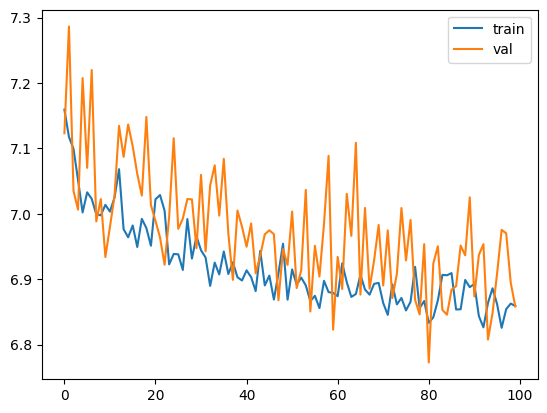

In [8]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

In [11]:
classifier = nn.Linear(1000, 10).to(device)

num_epochs = 100
batch_size = 1000
lr = 0.01
optimiser = torch.optim.AdamW(classifier.parameters(), lr=lr)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

c_train_losses = []
c_train_accs = []   
c_val_losses = []
c_val_accs = []

postfix = {}
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    loop.set_description(f'Epoch [{epoch}/{num_epochs}]')
    if epoch > 0:
        loop.set_postfix(postfix)
    epoch_train_loss = 0
    epoch_train_acc = 0
    for i, (x, y) in loop:
        x = model(x)
        y_pred = classifier(x)
        loss = F.cross_entropy(y_pred, y)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        epoch_train_loss += loss.item()
        epoch_train_acc += (y_pred.argmax(dim=1) == y).float().mean().item()

    c_train_losses.append(epoch_train_loss / len(train_loader))
    c_train_accs.append(epoch_train_acc / len(train_loader))
    
    with torch.no_grad():
        epoch_val_loss = 0
        epoch_val_acc = 0
        for x, y in val_loader:
            x = model(x)
            y_pred = classifier(x)
            loss = F.cross_entropy(y_pred, y)
            epoch_val_loss += loss.item()
            epoch_val_acc += (y_pred.argmax(dim=1) == y).float().mean().item()

        c_val_losses.append(epoch_val_loss / len(val_loader))
        c_val_accs.append(epoch_val_acc / len(val_loader))
    
    postfix = {
        'train_loss': c_train_losses[-1],
        'train_acc': c_train_accs[-1],
        'val_loss': c_val_losses[-1],
        'val_acc': c_val_accs[-1],
    }
    loop.set_postfix(postfix)
    loop.close()

plt.plot(c_train_losses, label='train')
plt.plot(c_val_losses, label='val')
plt.legend()
plt.show()

plt.plot(c_train_accs, label='train')
plt.plot(c_val_accs, label='val')
plt.legend()
plt.show()

KeyboardInterrupt: 